### Initialization

In [1]:
import nibabel as nib
from nilearn.image import resample_to_img
from nilearn import plotting
from ipywidgets import interact, widgets
import gmsh
from scipy.io import loadmat
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket
import os

hostname = socket.gethostname()
p = {}
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datd'] = '/d/DATD/datd/MD_TMS_EEG'
else:
    p['datd'] = '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datd/MD_TMS_EEG'
p['data'] = p['datd'] + '/data'
p['analysis'] = p['datd'] + '/analysis'
p['EEGfiles'] = p['datd'] + '/EEGfiles'
p['meta'] = p['analysis'] + '/meta_analysis'
p['df_fname'] = os.path.join(p['meta'], 'calib_filtered.csv')
p['simnibs_path'] = os.path.join(p['datd'], 'SIMNIBS_output')

# Load up summary data
summary_df = pd.read_csv(os.path.join(p['analysis'] + '/EEG_TMS_meta_Summary.csv'))

All_metadata = {row['Subject ID']: row for _, row in summary_df.iterrows()}
subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 24, 25, 26, 27]

stim_intensities = []
hemisphere_stimulated = []
for ss in subs:
    stim_intensities.append(All_metadata[ss]['Stim Intensity'])
    hemisphere_stimulated.append(All_metadata[ss]['Hemisphere stimulated'])
stim_dIdt = [round((a / 60) * 87 *1e6) for a in stim_intensities]


### Functions to load and read anatomicals and ROI

In [2]:
# Function to load nifty
def load_nii_file(fpath, T1):
    nii_img = nib.load(fpath)
    if nii_img.shape[0] != 320:
        nii_img = resample_to_img(fpath, T1, interpolation='nearest')
    data = nii_img.get_fdata()
    return data

# Function to compute average from mask
def calculate_average_over_mask(whole_brain, mask):
    masked_data = whole_brain[mask > 0]
    #print(masked_data.shape)
    average_value = masked_data.max() 
    #########print(average_value)
    return average_value

### Unique to sub24 for whom the ROIs were created using an anatomcial trick, be careful while running this, it overwrites the files

In [ ]:
## Create ROIs for sub24
def segregate_rois(roi_path, t1_path, subfoldpath):
    roi_loader = nib.load(t1_path)
    roi_data = load_nii_file(roi_path, t1_path)

    mid_x = roi_data.shape[0] // 2 - 6 # This was found by brute-force search
    
    rois = {'V1': 1, 'V2d': 2, 'V3d': 3, 'V3AB': 4}
    segregated_rois = {roi: {'left': None, 'right': None} for roi in rois}
    
    for roi_name, roi_value in rois.items():
        roi_mask = roi_data == roi_value
        lh = roi_mask.copy()
        rh = roi_mask.copy()
        lh[:mid_x, :, :] = 0
        rh[mid_x:, :, :] = 0
        lh_uint8 = lh.astype(np.uint8)
        rh_uint8 = rh.astype(np.uint8)
        #segregated_rois[roi_name]['left'] = lh
        #segregated_rois[roi_name]['right'] = rh
        lft_img = nib.Nifti1Image(lh_uint8, affine=roi_loader.affine)
        rght_img = nib.Nifti1Image(rh_uint8, affine=roi_loader.affine)
        nib.save(lft_img, f"{subfoldpath}/lh.{roi_name}.nii.gz")
        nib.save(rght_img, f"{subfoldpath}/rh.{roi_name}.nii.gz")
    return segregated_rois

subfoldpath = f"{p['simnibs_path']}/sub24"
t1_path = f"{subfoldpath}/T1.nii"
roi_path = f"{subfoldpath}/ROIs_V1-4-in-volume.nii.gz"
t1_data = load_nii_file(t1_path, t1_path)
roi_total = load_nii_file(roi_path, t1_path)

segregated_rois = segregate_rois(roi_path, t1_path, subfoldpath)

### Visualize the ROIs

In [ ]:
slice_toplot = 140
slice_num = roi_total.shape[0] // 2 -5
t1_plot = t1_data.copy()
#t1_plot[slice_num:, :, :] = 0
#slice_num = slice_num-1
#t1_plot = t1_data

roi_mask = roi_total == 2
plt.figure(figsize=(15, 15))
plt.imshow(t1_plot[:, slice_toplot, :], cmap='gray', origin='lower')
#plt.imshow(roi_mask[:, slice_toplot, :], cmap='hot', alpha=0.5, origin='lower')  # Overlay ROI
#plt.imshow(segregated_rois['V3d']['right'][:, slice_toplot, :], cmap='hot', alpha=0.5, origin='lower')
plt.axhline(y=slice_num)
#plt.title(f"{roi_name} - {hemisphere} Hemisphere")
plt.axis('off')
plt.show()

In [ ]:
slice_x = 1
slice_y = 1
slice_z = 1
def update_plot(slice_x, slice_y, slice_z):
    plt.figure(figsize=(15, 15))
    # Subplot for slice_x
    plt.subplot(131)
    plt.imshow(t1_plot[:, slice_x, :], cmap='gray', origin='lower')
    plt.title(f'Slice X: {slice_x}')
    plt.axis('off')
    # Subplot for slice_y
    plt.subplot(132)
    plt.imshow(t1_plot[slice_y, :, :], cmap='gray', origin='lower')
    plt.title(f'Slice Y: {slice_y}')
    plt.axis('off')
    # Subplot for slice_z
    plt.subplot(133)
    plt.imshow(t1_plot[:, :, slice_z], cmap='gray', origin='lower')
    plt.title(f'Slice Z: {slice_z}')
    plt.axis('off')
    plt.show()
# Create widgets for each slice
slice_x_widget = widgets.IntSlider(min=0, max=t1_data.shape[0] - 1, value=slice_x, description='Slice X:')
slice_y_widget = widgets.IntSlider(min=0, max=t1_data.shape[1] - 1, value=slice_y, description='Slice Y:')
slice_z_widget = widgets.IntSlider(min=0, max=t1_data.shape[2] - 1, value=slice_z, description='Slice Z:')
# Create an interactive plot
interact(update_plot, slice_x=slice_x_widget, slice_y=slice_y_widget, slice_z=slice_z_widget)

### Estimate E-field for each ROI

In [3]:
data = {}
meanarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
allvalsarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}

for idx, sub in enumerate(subs):
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }

    data[sub_id] = {roi_name: load_nii_file(path, file_paths['T1'])
                    for roi_name, path in file_paths.items()}
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    
    for roi_name, path in file_paths.items():
        roi_data = load_nii_file(path, f"{subfoldpath}/T1.nii")
        allvalsarray[roi_name].extend(metric_data[roi_data>0].flatten())
        mean_value = calculate_average_over_mask(metric_data, roi_data)
        meanarray[roi_name].append(mean_value)

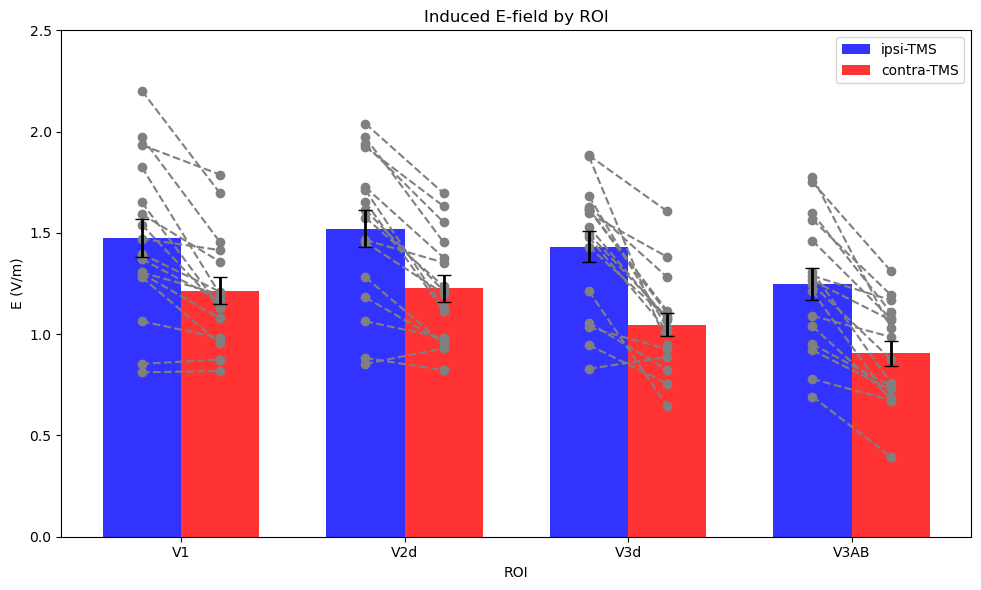

In [4]:
means = {roi: np.mean(values) for roi, values in meanarray.items()}
std_errors = {roi: np.std(values) / np.sqrt(len(values)) for roi, values in meanarray.items()}
roi_list = ['V1', 'V2d', 'V3d', 'V3AB']

fig, ax = plt.subplots(figsize=(10, 6))
n_groups = len(means) // 2
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

for i, roi in enumerate(roi_list):
    lh_mean = meanarray[f'lh{roi}']
    rh_mean = meanarray[f'rh{roi}']
    lh_x = index[i] - bar_width/2
    rh_x = lh_x + bar_width
    ax.plot([lh_x + bar_width/2, rh_x + bar_width/2], [lh_mean, rh_mean], 'grey', linestyle='--', marker='o')

left_bars = ax.bar(index, [means[f'lh{roi}'] for roi in roi_list],
                   bar_width, alpha=opacity, color='b',
                   yerr=[std_errors[f'lh{roi}'] for roi in roi_list],
                   label='ipsi-TMS', error_kw={'elinewidth':2, 'capsize':5})

right_bars = ax.bar(index + bar_width, [means[f'rh{roi}'] for roi in roi_list],
                    bar_width, alpha=opacity, color='r',
                    yerr=[std_errors[f'rh{roi}'] for roi in roi_list],
                    label='contra-TMS', error_kw={'elinewidth':2, 'capsize':5})
ax.set_xlabel('ROI')
ax.set_ylabel('E (V/m)')
ax.set_title('Induced E-field by ROI')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(roi_list)
ax.legend()

# Adding a grid, setting the limit and making layout tight
#ax.yaxis.grid(True)
ax.set_ylim([0, max(means.values()) + max(std_errors.values()) * 3])  # Adjust the y-axis limit to show error bars
plt.tight_layout()
plt.ylim([0, 2.5])
# Show the plot
#plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/efield_induced_by_roi.eps', format = 'eps', dpi = 1200)
plt.show()

### Find the outlier subjects with higher E-field in contralateral ROI

In [ ]:
for i, roi in enumerate(roi_list):
    for jj in range(len(subs)):
        sub_id = subs[jj]
        #meanarray[roi_name]
        lh_mean = meanarray[f'lh{roi}'][jj]
        rh_mean = meanarray[f'rh{roi}'][jj]
        if rh_mean > lh_mean:
            print(subs[jj], roi, lh_mean, rh_mean)

### Visualize histograms of E-field by voxels in ROIs

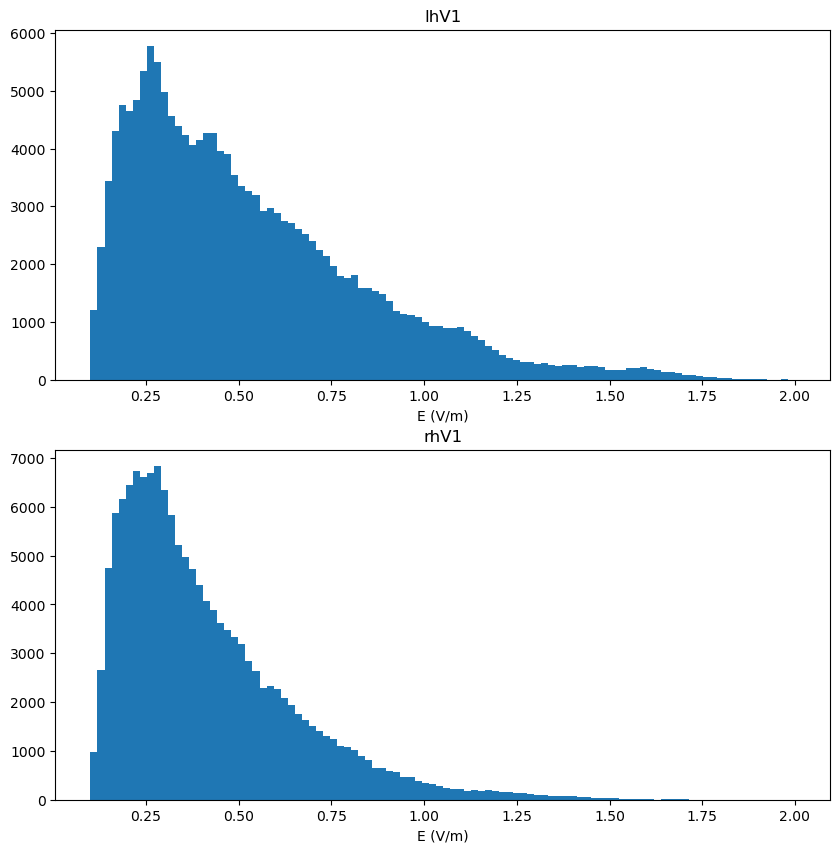

In [7]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
ax[0].hist(allvalsarray['lhV1'], bins = 100, range = (0.1, 2))
ax[1].hist(allvalsarray['rhV1'], bins = 100, range = (0.1, 2))
ax[0].set_title('lhV1')
ax[1].set_title('rhV1')
# ax[0].set_ylim([0, 500])
# ax[1].set_ylim([0, 500])
ax[0].set_xlabel('E (V/m)')
ax[1].set_xlabel('E (V/m)')
#plt.savefig('/d/DATA/hyper/conferences/Dake_SfN2023/hist_efield_V1_sub01.eps', format = 'eps', dpi = 1200)
plt.show()
#plt.xlim([0.1, 1])

### Check if E-field induced depends on the size of the ROI

In [10]:
sizearray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
Efieldarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
normalized_size = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
roi_list = ['T1', 'lhV1', 'rhV1', 'lhV2d', 'rhV2d', 'lhV3d', 'rhV3d', 'lhV3AB', 'rhV3AB']
for idx, sub in enumerate(subs):
    sub = subs[idx]
    sub_id = f"sub{sub:02d}"
    for roi_name in roi_list:
        sizearray[roi_name].append(np.sum(data[sub_id][roi_name]))
        Efieldarray[roi_name].append(meanarray[roi_name][idx])
        normalized_size[roi_name].append(np.mean(data[sub_id][roi_name]))

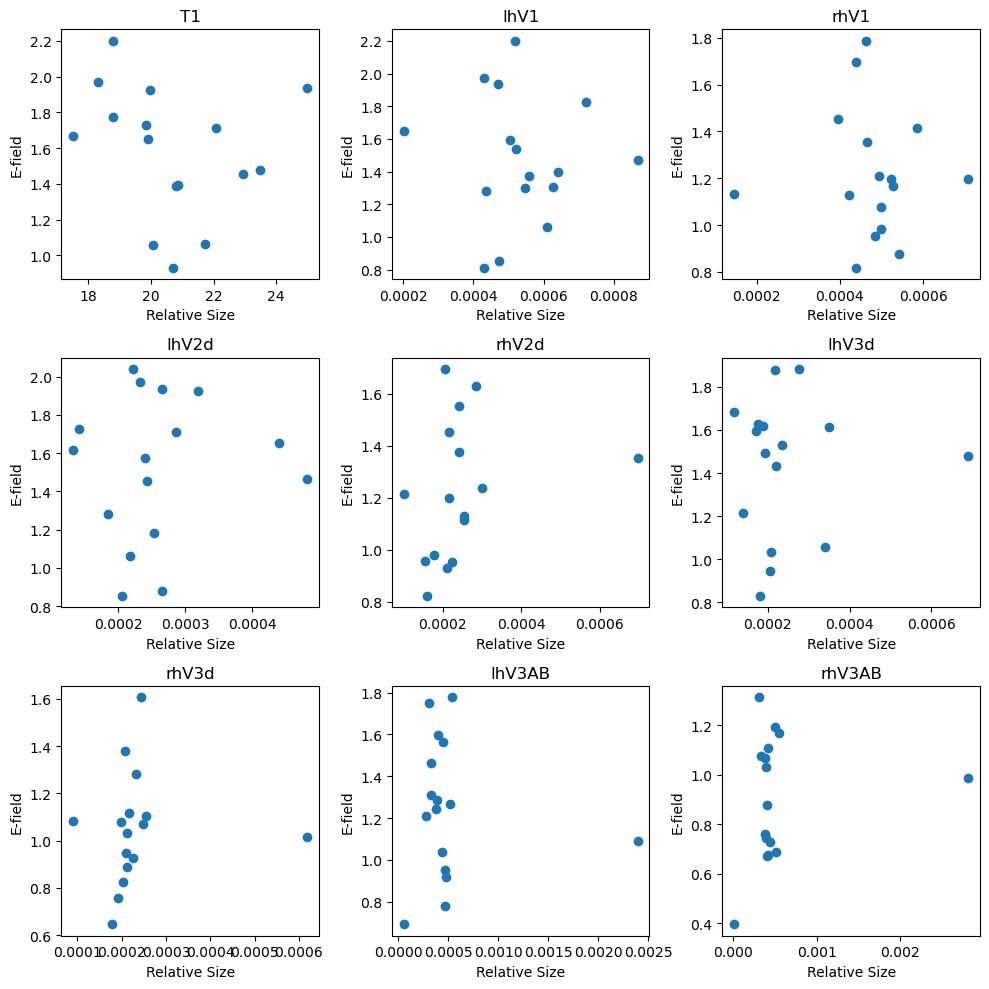

In [11]:
fig, axs = plt.subplots(3, 3, figsize = (10, 10))
axs = axs.flatten()
for ax, roi_name in zip(axs, roi_list):
    this_x = [normalized_size[roi_name]]
    this_y = [Efieldarray[roi_name]]
    ax.scatter(this_x, this_y)
    ax.set_title(roi_name)
    ax.set_xlabel('Relative Size')
    ax.set_ylabel('E-field')
plt.tight_layout()
plt.show()

### Load up behavioral data

In [12]:
df_calib_filt = pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/calib_filtered.csv')
df_calib_all5_filt = pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/calib_all5_filtered.csv')

In [13]:
temp_subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]
sess = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
loc = [1, 2, 8, 3, 4, 6, 4, 6, 5, 2, 6, 3, 4, 1, 4]
n_subs = len(temp_subs)

# temp_subs = [1, 3]
resolution = 100
Efield_holder = np.zeros((len(temp_subs), resolution-1))
#fig, axs = plt.subplots(n_subs, 2, figsize=(10, 5 * n_subs))
for idx, sub in enumerate(temp_subs):
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    sub_init = All_metadata[sub]['Subject Initials']
    if sub == 12:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    elif sub == 26: 
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    else:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5-fFit.nii.gz"
        
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }
    
    funcFitdata = load_nii_file(funcFitpath, file_paths['T1'])
    # Remove voxels below variance-explained threshold of 0.1
    ve_thresh = 0.1
    bad_voxels = np.where(funcFitdata[:, :, :, 1] < ve_thresh)
    polmap_data = funcFitdata[:, :, :, 0]
    polmap_data[bad_voxels] = np.nan
    polmap_data = np.rad2deg(polmap_data)

    # Change the polar angle coordinate space to match the coordinate space used in behavior
    polmap_data[(polmap_data>=0) & (polmap_data<=180)] = -polmap_data[(polmap_data>=0) & (polmap_data<=180)]
    polmap_data[(polmap_data>180) & (polmap_data<360)] = 360-polmap_data[(polmap_data>180) & (polmap_data<360)]
    #t1_data = nib.load(t1_path).get_fdata()
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    lhV1_data = load_nii_file(file_paths['lhV1'], file_paths['T1'])
    rhV1_data = load_nii_file(file_paths['rhV1'], file_paths['T1'])
    lhV2d_data = load_nii_file(file_paths['lhV2d'], file_paths['T1'])
    rhV2d_data = load_nii_file(file_paths['rhV2d'], file_paths['T1'])
    lhV3d_data = load_nii_file(file_paths['lhV3d'], file_paths['T1'])
    rhV3d_data = load_nii_file(file_paths['rhV3d'], file_paths['T1'])
    lhV3AB_data = load_nii_file(file_paths['lhV3AB'], file_paths['T1'])
    rhV3AB_data = load_nii_file(file_paths['rhV3AB'], file_paths['T1'])
    totalV_data = ((lhV1_data == 1) | (rhV1_data == 1)).astype(int)
    #totalV_data = ((lhV1_data == 1) | (rhV1_data == 1) | (lhV2d_data == 1) | (rhV2d_data == 1) | (lhV3d_data == 1) | (rhV3d_data == 1) | (lhV3AB_data == 1) | (rhV3AB_data == 1)).astype(int)
    normalize_Efield = metric_data/metric_data.max()

    polmap_data_flat = polmap_data.flatten()
    totalV_data_flat = totalV_data.flatten() 
    polmap_data_flat[totalV_data_flat != 1] = np.nan
    normalize_Efield_flat = normalize_Efield.flatten()
    valid_indices = ~np.isnan(polmap_data_flat)
    polmap_data_valid = polmap_data_flat[valid_indices]
    normalize_Efield_valid = normalize_Efield_flat[valid_indices]

    polar_angle_bins = np.linspace(min(polmap_data_valid), max(polmap_data_valid), num=resolution)  
    polar_angle_bin_indices = np.digitize(polmap_data_valid, polar_angle_bins)

    # Calculate the mean E-field magnitude for each bin
    mean_efield_per_bin = np.array([normalize_Efield_valid[polar_angle_bin_indices == i].mean() for i in range(1, len(polar_angle_bins))])
    mean_efield_per_bin = np.nan_to_num(mean_efield_per_bin)
    bin_middles = (polar_angle_bins[:-1] + polar_angle_bins[1:]) / 2
    x_plot = mean_efield_per_bin * np.cos(np.deg2rad(bin_middles))
    y_plot = mean_efield_per_bin * np.sin(np.deg2rad(bin_middles))

    df_tms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']<4) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['ispro']==1) ]
    df_notms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']<4) & (df_calib_all5_filt['istms']==0) & (df_calib_all5_filt['ispro']==1) ]
    tms_polang = np.rad2deg(df_tms['polang'])
    notms_polang = np.rad2deg(df_notms['polang'])

    bin_median = np.where(bin_middles-tms_polang.median()>0)
    #rot_idx = bin_median[0]
    Efield_holder[idx, :] = np.roll(mean_efield_per_bin, bin_median[0][0], axis = 0)

/users/mrugank/.conda/envs/eegmne/lib/python3.12/site-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_8117/892404610.py:89: RuntimeWarning: Mean of empty slice.
  mean_efield_per_bin = np.array([normalize_Efield_valid[polar_angle_bin_indices == i].mean() for i in range(1, len(polar_angle_bins))])
/users/mrugank/.conda/envs/eegmne/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


: 

In [ ]:
plt.figure()
for ii in range(len(temp_subs)):
    plt.plot(bin_middles, Efield_holder[0,:])

plt.xlabel('Polar Angle (degrees)')
plt.ylabel('Normalized E-field')
plt.xlim([-180, 180])
plt.title('E-field Magnitude by Polar Angle Bin')
plt.show()

In [ ]:
plt.figure()
y = np.mean(Efield_holder, 0)
y_err = np.nanstd(Efield_holder, 0)/np.sqrt(len(temp_subs))
plt.plot(bin_middles, y, 'k')

plt.fill_between(bin_middles, y-y_err, y+y_err, alpha=0.5, linewidth=0, color='b')
plt.xlabel('Polar Angle (degrees)')
plt.ylabel('Normalized E-field')
plt.xlim([-180, 180])
plt.title('E-field Magnitude by Polar Angle Bin')
plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/predicted_efield_peak.eps', format = 'eps', dpi = 1200)
plt.show()


In [1]:
temp_subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]
sess = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
loc = [1, 2, 8, 3, 4, 6, 4, 6, 5, 2, 6, 3, 4, 1, 4]
n_subs = len(temp_subs)

fig, axs = plt.subplots(n_subs, 2, figsize=(10, 5 * n_subs))
for idx, sub in enumerate(temp_subs):
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    sub_init = All_metadata[sub]['Subject Initials']
    if sub == 12:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    elif sub == 26: 
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    else:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5-fFit.nii.gz"
        
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }
    
    funcFitdata = load_nii_file(funcFitpath, file_paths['T1'])
    # Remove voxels below variance-explained threshold of 0.1
    ve_thresh = 0.1
    bad_voxels = np.where(funcFitdata[:, :, :, 1] < ve_thresh)
    polmap_data = funcFitdata[:, :, :, 0]
    polmap_data[bad_voxels] = np.nan
    polmap_data = np.rad2deg(polmap_data)

    # Change the polar angle coordinate space to match the coordinate space used in behavior
    polmap_data[(polmap_data>=0) & (polmap_data<=180)] = -polmap_data[(polmap_data>=0) & (polmap_data<=180)]
    polmap_data[(polmap_data>180) & (polmap_data<360)] = 360-polmap_data[(polmap_data>180) & (polmap_data<360)]
    #t1_data = nib.load(t1_path).get_fdata()
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    lhV1_data = load_nii_file(file_paths['lhV1'], file_paths['T1'])
    rhV1_data = load_nii_file(file_paths['rhV1'], file_paths['T1'])
    lhV2d_data = load_nii_file(file_paths['lhV2d'], file_paths['T1'])
    rhV2d_data = load_nii_file(file_paths['rhV2d'], file_paths['T1'])
    lhV3d_data = load_nii_file(file_paths['lhV3d'], file_paths['T1'])
    rhV3d_data = load_nii_file(file_paths['rhV3d'], file_paths['T1'])
    lhV3AB_data = load_nii_file(file_paths['lhV3AB'], file_paths['T1'])
    rhV3AB_data = load_nii_file(file_paths['rhV3AB'], file_paths['T1'])
    totalV1_data = ((lhV1_data == 1) | (rhV1_data == 1)).astype(int)
    totalV_data = ((lhV1_data == 1) | (rhV1_data == 1) | (lhV2d_data == 1) | (rhV2d_data == 1) | (lhV3d_data == 1) | (rhV3d_data == 1) | (lhV3AB_data == 1) | (rhV3AB_data == 1)).astype(int)
    normalize_Efield = metric_data/metric_data.max()

    polmap_data_flat = polmap_data.flatten()
    totalV_data_flat = totalV_data.flatten() 
    polmap_data_flat[totalV_data_flat != 1] = np.nan
    normalize_Efield_flat = normalize_Efield.flatten()
    valid_indices = ~np.isnan(polmap_data_flat)
    polmap_data_valid = polmap_data_flat[valid_indices]
    normalize_Efield_valid = normalize_Efield_flat[valid_indices]

    polar_angle_bins = np.linspace(min(polmap_data_valid), max(polmap_data_valid), num=100)  
    polar_angle_bin_indices = np.digitize(polmap_data_valid, polar_angle_bins)

    # Calculate the mean E-field magnitude for each bin
    mean_efield_per_bin = np.array([normalize_Efield_valid[polar_angle_bin_indices == i].mean() for i in range(1, len(polar_angle_bins))])
    mean_efield_per_bin = np.nan_to_num(mean_efield_per_bin)
    bin_middles = (polar_angle_bins[:-1] + polar_angle_bins[1:]) / 2
    x_plot = mean_efield_per_bin * np.cos(np.deg2rad(bin_middles))
    y_plot = mean_efield_per_bin * np.sin(np.deg2rad(bin_middles))

    axs[idx, 0].plot(x_plot, y_plot, 'b--')
    axs[idx, 0].set_xlim([-np.max(mean_efield_per_bin), np.max(mean_efield_per_bin)])
    axs[idx, 0].set_ylim([-np.max(mean_efield_per_bin), np.max(mean_efield_per_bin)])
    axs[idx, 0].set_title(f"Predicted E-field: {sub_id}")

    phosphPath = f"{p['data']}/phosphene_data/{sub_id}/PhospheneReport_{sub_id}_sess{sess[idx]:02d}_antitype_mirror.mat"
    actual_pmap = loadmat(phosphPath)['PhosphReport'][0, loc[idx]-1]['StimuliSampleSpace'].astype(np.float64)
    xpix_max = 1920
    ypix_max = 1080
    actual_pmap[:, 0] = (actual_pmap[:, 0] - xpix_max/2)/xpix_max
    actual_pmap[:, 1] = (actual_pmap[:, 1] - ypix_max/2)#/xpix_max
    actual_pmap[:, 1] = (- actual_pmap[:, 1])/ypix_max
    # if this_hemi == 'Left':
    axs[idx, 1].plot(actual_pmap[:, 0], actual_pmap[:, 1], 'k*', label='inPF')
    axs[idx, 1].plot(-actual_pmap[:, 0], actual_pmap[:, 1], 'r*', label='outPF')
    # else:
    #     axs[idx, 1].plot(-actual_pmap[:, 0], actual_pmap[:, 1], 'k*', label='inPF')
    #     axs[idx, 1].plot(actual_pmap[:, 0], actual_pmap[:, 1], 'r*', label='outPF')
    axs[idx, 1].set_xlim([-1/2, 1/2])
    axs[idx, 1].set_ylim([-1/2, 1/2])
    axs[idx, 1].legend()
    axs[idx, 1].set_title('Actual stimulus location')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
temp_subs = [1, 3, 5, 6, 7, 10, 14, 15, 17, 22, 23, 25, 27]
#temp_subs = [1, 3, 5]
# sess = [1, 2, 1]
# loc = [1, 2, 8]

sess = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
loc = [1, 2, 8, 3, 4, 6, 6, 5, 2, 6, 3, 4, 4]
n_subs = len(temp_subs)
# n_rows = round(n_subs)

fig, axs = plt.subplots(n_subs, 4, figsize=(20, 5 * n_subs))
for idx, sub in enumerate(temp_subs):
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    sub_init = All_metadata[sub]['Subject Initials']
    funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5-fFit.nii.gz"
        
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }
    
    funcFitdata = load_nii_file(funcFitpath, file_paths['T1'])
    # Remove voxels below variance-explained threshold of 0.1
    ve_thresh = 0.1
    bad_voxels = np.where(funcFitdata[:, :, :, 1] < ve_thresh)
    polmap_data = funcFitdata[:, :, :, 0]
    polmap_data[bad_voxels] = np.nan
    polmap_data = np.rad2deg(polmap_data)

    # Change the polar angle coordinate space to match the coordinate space used in behavior
    polmap_data[(polmap_data>=0) & (polmap_data<=180)] = -polmap_data[(polmap_data>=0) & (polmap_data<=180)]
    polmap_data[(polmap_data>180) & (polmap_data<360)] = 360-polmap_data[(polmap_data>180) & (polmap_data<360)]
    #t1_data = nib.load(t1_path).get_fdata()
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    lhV1_data = load_nii_file(file_paths['lhV1'], file_paths['T1'])
    rhV1_data = load_nii_file(file_paths['rhV1'], file_paths['T1'])
    lhV2d_data = load_nii_file(file_paths['lhV2d'], file_paths['T1'])
    rhV2d_data = load_nii_file(file_paths['rhV2d'], file_paths['T1'])
    lhV3d_data = load_nii_file(file_paths['lhV3d'], file_paths['T1'])
    rhV3d_data = load_nii_file(file_paths['rhV3d'], file_paths['T1'])
    lhV3AB_data = load_nii_file(file_paths['lhV3AB'], file_paths['T1'])
    rhV3AB_data = load_nii_file(file_paths['rhV3AB'], file_paths['T1'])
    totalV1_data = ((lhV1_data == 1) | (rhV1_data == 1)).astype(int)
    totalV_data = ((lhV1_data == 1) | (rhV1_data == 1) | (lhV2d_data == 1) | (rhV2d_data == 1) | (lhV3d_data == 1) | (rhV3d_data == 1) | (lhV3AB_data == 1) | (rhV3AB_data == 1)).astype(int)
    normalize_Efield = metric_data/metric_data.max()

    polmap_data_flat = polmap_data.flatten()
    totalV_data_flat = totalV_data.flatten() 
    polmap_data_flat[totalV_data_flat != 1] = np.nan
    normalize_Efield_flat = normalize_Efield.flatten()
    valid_indices = ~np.isnan(polmap_data_flat)
    polmap_data_valid = polmap_data_flat[valid_indices]
    normalize_Efield_valid = normalize_Efield_flat[valid_indices]

    polar_angle_bins = np.linspace(min(polmap_data_valid), max(polmap_data_valid), num=180)  
    polar_angle_bin_indices = np.digitize(polmap_data_valid, polar_angle_bins)

    # Calculate the mean E-field magnitude for each bin
    mean_efield_per_bin = np.array([normalize_Efield_valid[polar_angle_bin_indices == i].mean() for i in range(1, len(polar_angle_bins))])
    mean_efield_per_bin = np.nan_to_num(mean_efield_per_bin)
    bin_middles = (polar_angle_bins[:-1] + polar_angle_bins[1:]) / 2
    x_plot = mean_efield_per_bin * np.cos(np.deg2rad(bin_middles))
    y_plot = mean_efield_per_bin * np.sin(np.deg2rad(bin_middles))

    axs[idx, 0].plot(x_plot, y_plot, 'b--')
    axs[idx, 0].set_xlim([-np.max(mean_efield_per_bin), np.max(mean_efield_per_bin)])
    axs[idx, 0].set_ylim([-np.max(mean_efield_per_bin), np.max(mean_efield_per_bin)])
    axs[idx, 0].set_title('Predicted E-field')

    actual_pmap = loadmat(phosphPath)['PhosphReport'][0, loc[idx]-1]['StimuliSampleSpace'].astype(np.float64)
    xpix_max = 1920
    ypix_max = 1080
    actual_pmap[:, 0] = (actual_pmap[:, 0] - xpix_max/2)/xpix_max
    actual_pmap[:, 1] = (actual_pmap[:, 1] - ypix_max/2)#/xpix_max
    actual_pmap[:, 1] = (- actual_pmap[:, 1])/ypix_max
    axs[idx, 1].plot(actual_pmap[:, 0], actual_pmap[:, 1], 'k*', label='inPF')
    axs[idx, 1].plot(-actual_pmap[:, 0], actual_pmap[:, 1], 'r*', label='outPF')
    axs[idx, 1].set_xlim([-1/2, 1/2])
    axs[idx, 1].set_ylim([-1/2, 1/2])
    axs[idx, 1].legend()
    axs[idx, 1].set_title('Actual stimulus location')

    df_tms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']==4) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['ispro']==1)]
    df_notms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']<4) & (df_calib_all5_filt['istms']==0) & (df_calib_all5_filt['ispro']==1)]
    tms_polang = np.rad2deg(df_tms['polang'])
    notms_polang = np.rad2deg(df_notms['polang'])
    tms_err = df_tms['ierr']
    notms_err = df_notms['ierr']

    tms_polang_bin_idx = np.digitize(tms_polang, polar_angle_bins)
    notms_polang_bin_idx = np.digitize(notms_polang, polar_angle_bins)
    tms_err_per_bin = np.array([tms_err[tms_polang_bin_idx == i].mean() for i in range(1, len(polar_angle_bins))])
    tms_err_per_bin = np.nan_to_num(tms_err_per_bin)
    notms_err_per_bin = np.array([notms_err[notms_polang_bin_idx == i].mean() for i in range(1, len(polar_angle_bins))])
    notms_err_per_bin = np.nan_to_num(notms_err_per_bin)
    rel_err_per_bin = np.divide((tms_err_per_bin-notms_err_per_bin), notms_err_per_bin, where=notms_err_per_bin!=0)

    x_err = tms_err_per_bin * np.cos(np.deg2rad(bin_middles))
    y_err = tms_err_per_bin * np.sin(np.deg2rad(bin_middles))
    axs[idx, 2].plot(x_err, y_err, 'r--', label='TMS')
    x_err = notms_err_per_bin * np.cos(np.deg2rad(bin_middles))
    y_err = notms_err_per_bin * np.sin(np.deg2rad(bin_middles))
    axs[idx, 2].plot(x_err, y_err, 'b--', label='No TMS')
    axs[idx, 2].set_xlim([-np.nanmax(tms_err_per_bin), np.nanmax(tms_err_per_bin)])
    axs[idx, 2].set_ylim([-np.nanmax(tms_err_per_bin), np.nanmax(tms_err_per_bin)])
    axs[idx, 2].legend()
    axs[idx, 2].set_title('Early vs NoTMS')

    df_tms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']<4) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['ispro']==1)]
    df_notms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']<4) & (df_calib_all5_filt['istms']==0) & (df_calib_all5_filt['ispro']==1)]
    tms_polang = np.rad2deg(df_tms['polang'])
    notms_polang = np.rad2deg(df_notms['polang'])
    tms_err = df_tms['ierr']
    notms_err = df_notms['ierr']

    tms_polang_bin_idx = np.digitize(tms_polang, polar_angle_bins)
    notms_polang_bin_idx = np.digitize(notms_polang, polar_angle_bins)
    tms_err_per_bin = np.array([tms_err[tms_polang_bin_idx == i].mean() for i in range(1, len(polar_angle_bins))])
    tms_err_per_bin = np.nan_to_num(tms_err_per_bin)
    notms_err_per_bin = np.array([notms_err[notms_polang_bin_idx == i].mean() for i in range(1, len(polar_angle_bins))])
    notms_err_per_bin = np.nan_to_num(notms_err_per_bin)
    rel_err_per_bin = np.divide((tms_err_per_bin-notms_err_per_bin), notms_err_per_bin, where=notms_err_per_bin!=0)

    x_err = tms_err_per_bin * np.cos(np.deg2rad(bin_middles))
    y_err = tms_err_per_bin * np.sin(np.deg2rad(bin_middles))
    axs[idx, 3].plot(x_err, y_err, 'r--', label='TMS')
    x_err = notms_err_per_bin * np.cos(np.deg2rad(bin_middles))
    y_err = notms_err_per_bin * np.sin(np.deg2rad(bin_middles))
    axs[idx, 3].plot(x_err, y_err, 'b--', label='No TMS')
    axs[idx, 3].set_xlim([-np.nanmax(tms_err_per_bin), np.nanmax(tms_err_per_bin)])
    axs[idx, 3].set_ylim([-np.nanmax(tms_err_per_bin), np.nanmax(tms_err_per_bin)])
    axs[idx, 3].legend()
    axs[idx, 3].set_title('Middle vs NoTMS')
plt.show()

In [ ]:
slice_x = 1
slice_y = 1
slice_z = 1
slice_m = 0
polmap_to_plot = polmap_data.copy()
polmap_to_plot[(polmap_to_plot > 0) & (polmap_to_plot < np.pi)] = np.nan
def update_plot(slice_x, slice_y, slice_z):
    plt.figure(figsize=(15, 15))
    # Subplot for slice_x
    plt.subplot(231)
    plt.imshow(t1_data[:, slice_x, :], cmap='gray', origin='lower')
    plt.title(f'Slice X: {slice_x}')
    plt.axis('off')
    # Subplot for slice_y
    plt.subplot(232)
    plt.imshow(t1_data[slice_y, :, :], cmap='gray', origin='lower')
    plt.title(f'Slice Y: {slice_y}')
    plt.axis('off')
    # Subplot for slice_z
    plt.subplot(233)
    plt.imshow(t1_data[:, :, slice_z], cmap='gray', origin='lower')
    plt.title(f'Slice Z: {slice_z}')
    plt.axis('off')

    plt.subplot(234)
    plt.imshow(polmap_to_plot[:, slice_x, :], cmap='inferno', origin='lower')
    plt.title(f'Slice X: {slice_x}')
    plt.axis('off')
    # Subplot for slice_y
    plt.subplot(235)
    plt.imshow(polmap_to_plot[slice_y, :, :], cmap='inferno', origin='lower')
    plt.title(f'Slice Y: {slice_y}')
    plt.axis('off')
    # Subplot for slice_z
    plt.subplot(236)
    plt.imshow(polmap_to_plot[:, :, slice_z], cmap='inferno', origin='lower')
    plt.title(f'Slice Z: {slice_z}')
    plt.axis('off')

    plt.show()
# Create widgets for each slice
slice_x_widget = widgets.IntSlider(min=0, max=t1_data.shape[0] - 1, value=slice_x, description='Slice X:')
slice_y_widget = widgets.IntSlider(min=0, max=t1_data.shape[1] - 1, value=slice_y, description='Slice Y:')
slice_z_widget = widgets.IntSlider(min=0, max=t1_data.shape[2] - 1, value=slice_z, description='Slice Z:')
# Create an interactive plot
interact(update_plot, slice_x=slice_x_widget, slice_y=slice_y_widget, slice_z=slice_z_widget)

In [ ]:
# df_tms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==27) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['instimVF']==1)]
# df_notms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==27) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['instimVF']==0)]
df_tms = df_calib_all5_filt[(df_calib_all5_filt['hemistimulated']=='Left') & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['instimVF']==1)]
df_notms = df_calib_all5_filt[(df_calib_all5_filt['hemistimulated']=='Left') & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['instimVF']==0)]
tms_polang = np.rad2deg(df_tms['polang'])
tms_err = df_tms['ierr']
notms_polang = np.rad2deg(df_notms['polang'])
notms_err = df_notms['ierr']
nbins = 20
min_pol = np.min(tms_polang)
max_pol = np.max(tms_polang)
bins = np.linspace(min_pol, max_pol, nbins+1) 

# Mirror these polar angles across the vertical meridian
# notms_polang_mirrored = np.where((tms_polang >= 0) & (tms_polang <= 180), -tms_polang, 
#                                  np.where((tms_polang < 0) & (tms_polang >= -180), abs(tms_polang), tms_polang))
# notms_polang_mirrored = np.where(notms_polang_mirrored == -180, 180, notms_polang_mirrored)
notms_polang_mirrored = np.where((notms_polang >= 0) & (notms_polang <= 180), 180-notms_polang, 
                                 np.where((notms_polang < 0) & (notms_polang >= -180), -(180-np.abs(notms_polang)), notms_polang))

tms_bin_indices = np.digitize(tms_polang, bins)
notms_bin_indices = np.digitize(notms_polang_mirrored, bins, right=True)

df_tms['bin'] = tms_bin_indices
df_notms['bin'] = notms_bin_indices

mean_tms_err_per_bin = df_tms.groupby('bin')['ierr'].mean()
mean_notms_err_per_bin = df_notms.groupby('bin')['ierr'].mean()

bins_df = pd.DataFrame(index=range(1, nbins+2))
mean_tms_err_per_bin = bins_df.join(mean_tms_err_per_bin, how='left').fillna(0)
mean_notms_err_per_bin = bins_df.join(mean_notms_err_per_bin, how='left').fillna(0)

comparison_df = pd.DataFrame({
    'bin_edges': bins,
    'mean_tms_err': mean_tms_err_per_bin['ierr'].values,
    'mean_notms_err': mean_notms_err_per_bin['ierr'].values,
    'relative_err': mean_tms_err_per_bin['ierr'].values/mean_notms_err_per_bin['ierr'].values - 1,
})
print(comparison_df)

# f, axs = plt.subplots(2, 1)    
# axs[0].plot(, , 'ro')
# axs[1].plot(, , 'ro')